# Evaluating UCE in zero-shot setting

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import logging
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import cell_embeddings, scgpt_forward, data, model_output
from sc_foundation_evals.helpers.custom_logging import log

log.setLevel(logging.INFO)

## Setting up variables

Define some variables, that we will rely on later, starting with paths and run configs.

In [8]:
# specify the path to anndata object
dataset_path = "./output/pancreas_scib/UCE/pancreas_scib_uce_adata.h5ad"
# in which column in adata.obs are gene names stored? if they are in index, the index will be copied to a column with this name
gene_col = "gene_symbols"
# batch column found in adata.obs
batch_col = "tech" #"batch"
# where are labels stored in adata.obs? 
label_cols = ["celltype"]
# where the raw counts are stored?
layer_key = "counts"
# are the values log_norm already?
log_norm = False

## Loading model and data

In [9]:
input_data = data.InputData(adata_dataset_path = dataset_path)

INFO     | 2024-05-27 21:13:22 | Loading data from ../../output/UCE/UCEpancreas_scib_uce_adata.h5ad


In [10]:
input_data.adata.X.shape

(16382, 15991)

In [12]:
input_data.adata.obsm["X_uce"].shape

(16382, 1280)

# Reference mapping and transfer the annotations

1. extract cell embeddings: bash ../scripts/run_UCE_embed.sh

2. run the notebook

In [13]:
import faiss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [14]:
use_rep_key = "X_uce"

In [17]:
ref_batch = ['indrop', 'celseq2', 'celseq']
input_data.adata.obs["is_ref"] = input_data.adata.obs["batch"].isin(ref_batch)
input_data.adata.obs

,tech,celltype,size_factors,batch,n_genes,is_ref
D101_5,celseq,gamma,0.028492,celseq,1857,True
D101_43,celseq,gamma,0.079348,celseq,3724,True
D101_93,celseq,gamma,0.037932,celseq,2261,True
D102_4,celseq,gamma,0.047685,celseq,2653,True
D172444_23,celseq,gamma,0.038683,celseq,2226,True
...,...,...,...,...,...,...
Sample_1594,smarter,gamma,1.000000,smarter,5841,False
Sample_1595,smarter,gamma,1.000000,smarter,5195,False
Sample_1597,smarter,gamma,1.000000,smarter,6356,False
Sample_1598,smarter,gamma,1.000000,smarter,4169,False


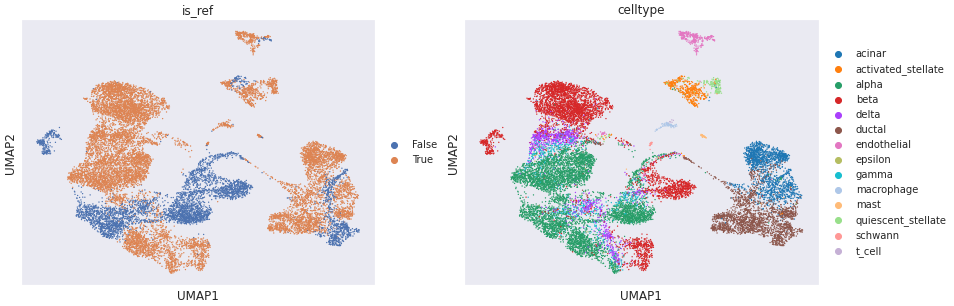

In [18]:
#! plot the figure using sc.tl.umap or plt.scatter
adata = input_data.adata.copy()
adata.obs["is_ref"] = adata.obs["is_ref"].astype("category")
sc.pp.neighbors(adata, use_rep=use_rep_key)
sc.tl.umap(adata)
fig = sc.pl.umap(
    adata, color=["is_ref", "celltype"], layer=use_rep_key,
    # wspace=0.4, frameon=True, ncols=1,
    return_fig=True
)
fig.tight_layout()
# fig.savefig("../../output/geneformer/6L/test.png")

In [21]:
ref_adata = adata[np.where(input_data.adata.obs["batch"].isin(ref_batch))[0]]
test_adata = adata[~np.where(input_data.adata.obs["batch"].isin(ref_batch))[0]]

In [22]:
ref_cell_embeddings = ref_adata.obsm[use_rep_key]
test_embed = test_adata.obsm[use_rep_key]

k = 10  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_embed, k)

idx_list=[i for i in range(test_embed.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    idx = labels[k]
    pred = ref_adata.obs[label_cols[-1]][idx].value_counts()
    preds.append(pred.index[0])
gt = test_adata.obs[label_cols[-1]].to_numpy()

In [23]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

{'accuracy': 0.9212346095462979,
 'precision': 0.9182114794406088,
 'recall': 0.8091543061797265,
 'macro_f1': 0.8310254507716587}

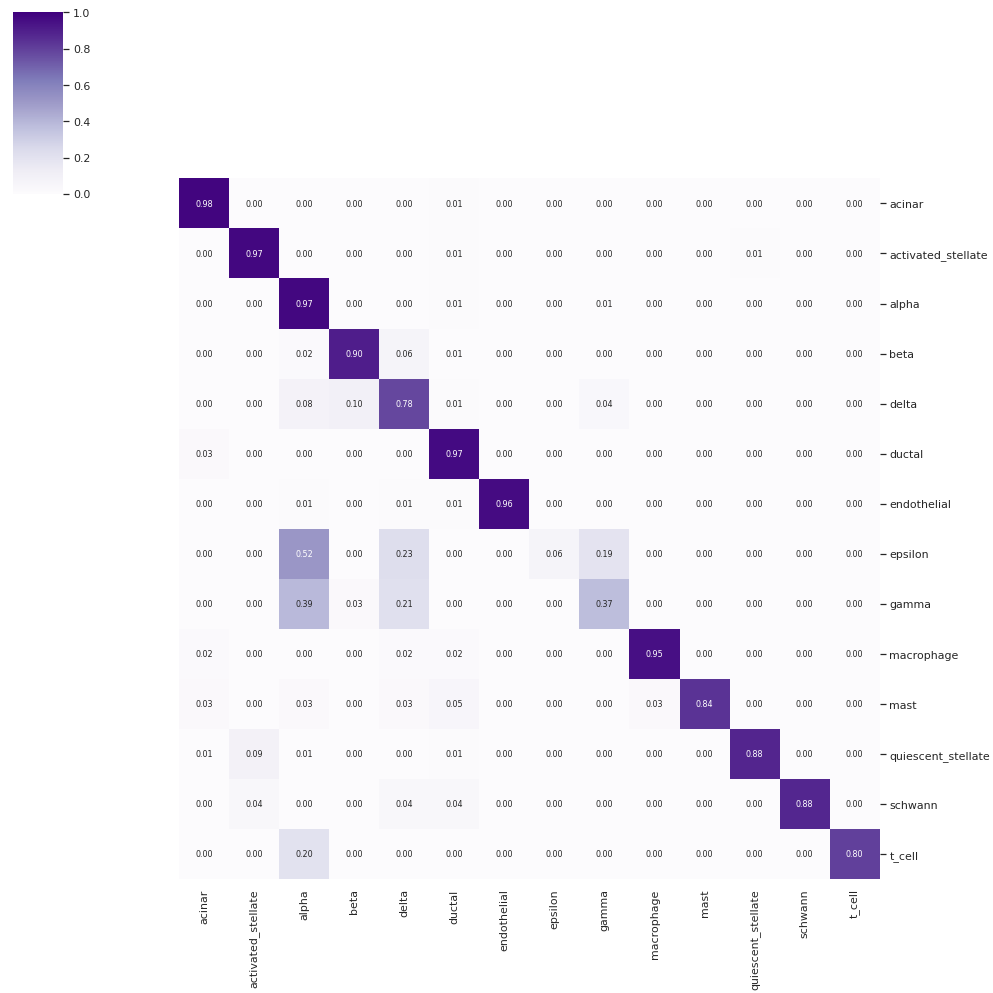

In [24]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,fmt=".2f", 
                    annot_kws={'size': 8}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14),
                    )